# Simplified Linear Regression for 5‑Day Stock Price Forecast

In [91]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import matplotlib.pyplot as plt


In [ ]:
def data_preproc(csv_file, lag = 15, forecast = 5):
    # Load & sort chronologically
    df = pd.read_csv(csv_file, parse_dates=['Date'])
    df.sort_values('Date', inplace=True)

    feature_cols = ["Open", "High", "Low", "Close", "Volume"]

    # Create lag features
    for i in range(1, lag + 1):
        for col in feature_cols:
            df[f"{col}_lag{i}"] = df[col].shift(i)

    # Create target (Close price `forecast` days ahead)
    df["target"] = df["Close"].shift(-forecast)

    # Drop rows containing NaNs produced by shifting
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # assemble X, y
    lag_feature_cols = [f"{col}_lag{i}" for i in range(1, lag + 1) for col in feature_cols]
    X = df[lag_feature_cols]
    y = df["target"]
    dates = df["Date"] 

    return X, y, dates

In [ ]:
def split_data(X, y, dates, train_ratio = 0.70, val_ratio = 0.15):
    # Chronological train / val / test split (70/15/15)
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]
    d_test = dates.iloc[val_end:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test, d_test)

In [102]:
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

In [ ]:
def run_linear_regression(csv_file, lag = 15, forecast = 5):
    # Data Preprocessing
    X, y, dates = data_preproc(csv_file, lag, forecast)

    # Chronological train / val / test split (70/15/15)
    (X_train, y_train), (X_val, y_val), (X_test, y_test, d_test) = split_data(X, y, dates)

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # Fit model to linear regressor and evaluate predictions
    model = LinearRegression().fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    metrics = {
        "Train": eval_metrics(y_train, y_train_pred),
        "Validation": eval_metrics(y_val, y_val_pred),
        "Test": eval_metrics(y_test, y_test_pred)
    }

    # Returns metrics, model, dates, y_test, y_pred
    return metrics, model, d_test.reset_index(drop=True), y_test.reset_index(drop=True), y_test_pred


,MSE,RMSE,MAE,R²
Train,8.372598,2.893544,2.067368,0.991325
Validation,13.283422,3.644643,2.800462,0.980717
Test,52.130585,7.220151,4.491682,0.952609


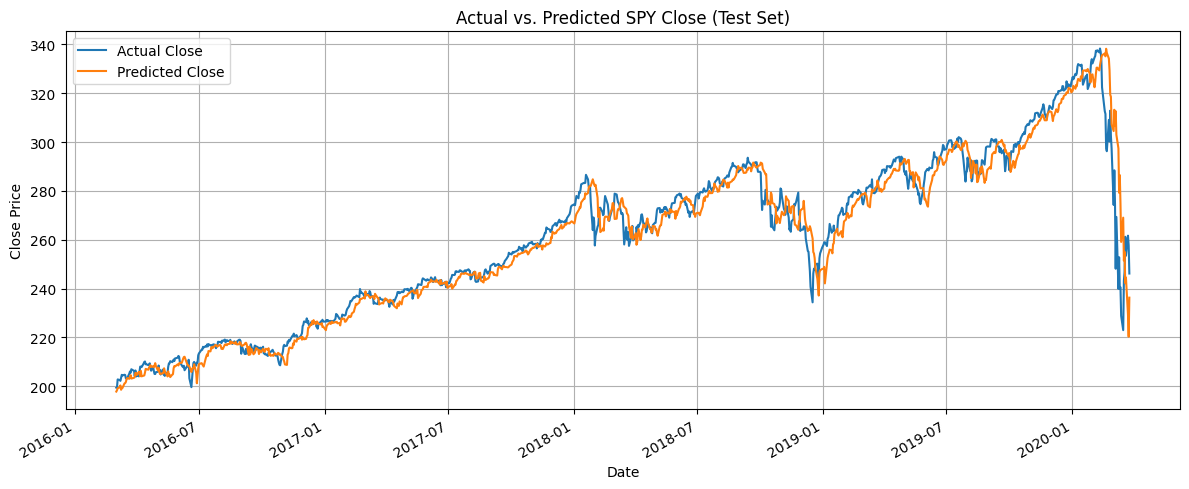

In [110]:
# Visualize results
metrics, model, dates_test, y_test, y_pred_test = run_linear_regression('../data/etfs/SPY.csv')
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
display(df_metrics)

actual = pd.Series(y_test.values, index=dates_test, name='Actual Close')
pred   = pd.Series(y_pred_test,       index=dates_test, name='Predicted Close')
plot_df = pd.concat([actual, pred], axis=1)

ax = plot_df.plot(figsize=(12,5), grid=True)
ax.set_title("Actual vs. Predicted SPY Close (Test Set)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
plt.tight_layout()
plt.show()